<a href="https://colab.research.google.com/github/edusporto/mac0417/blob/main/EP3_2_Classifica%C3%A7%C3%A3o_dos_Objetos_de_Interesse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EP3.1 de MAC0417 - Classificação dos Objetos de Interesse

## Grupo:

Julia Olsson Rego - 10689460

Eduardo Sandalo Porto - 11796510

Elias Kento Tomiyama - 3182204

## Google Drive:

https://drive.google.com/drive/folders/1k6pL_HN4VXwsiBSiIXk0jskFAfDcKR5-?usp=sharing

## Repositório:

https://github.com/edusporto/mac0417


## Setup

In [ ]:
from time import time
import logging
import os
import random
import skimage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from tqdm.notebook import tqdm
from skimage import io 
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
# Usar as imagens armazenadas no Google Drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MAC0417')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ler dataset dos metadados
data = pd.read_csv('metadados.csv')
data = data.sort_values(by=['Fundo','Local','Iluminacao','Classe']) # Organizar dataset
data = data.reset_index(drop=True)

In [ ]:
# Ler bancos de imagens
dataset_f = 'segmentacaoManual' # OBS: Não estamos mais usando `BancoImagensMin`
imgs_f = [f"{dataset_f}/{img_f}" for img_f in os.listdir(dataset_f)]
imgs_f = [img_f for img_f in imgs_f if '.jpg' in img_f] # apenas guarda imagens

dataset_g = 'segmentacaoAutomatico' # OBS: Não estamos mais usando `BancoImagensMin`
imgs_g = [f"{dataset_g}/{img_g}" for img_g in os.listdir(dataset_g)]
imgs_g = [img_g for img_g in imgs_g if '.jpg' in img_g] # apenas guarda imagens

In [ ]:
def extract_file_name(file_name):
  """
  Com um input `pasta/arquivo.ext`, retorna uma string `arquivo`.
  Usado para extrair o nome dos arquivos do dataset e salvá-los em
  outra pasta.
  """
  return file_name.split("/")[1].split(".")[0]
  
def extract_class(file_name):
  """
  Com um input `pasta/arquivo-class.ext`, retorna uma string `class`.
  Usado para extrair a classe de um dataset.
  """
  return file_name.split("-")[1].split(".")[0]

## Classificação dos Objetos de Interesse

O propósito desta parte do EP é criar um modelo para a classificação dos objetos cujas fotografias foram tiradas no EP1.

O algoritmo de classificação será construído com base [neste link](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

O pipeline do classificador é o seguinte:

![](https://edisciplinas.usp.br/pluginfile.php/6004503/mod_wiki/intro/EP3_pipeline-Page-2.png)

A *imagem binária* inicial é produzida pela parte 1 do EP3 (EP3.1).

### Carregando os dados e conjuntos de treinamento e testes para segmentação manual

Vamos carregar as imagens das máscaras manualmente produzidas:

In [ ]:
img_masks = [io.imread(img_f)for img_f in imgs_f]

Precisamos também de algumas informações sobre as imagens:

In [ ]:
# Quantidade de imagens para o treinamento
n_samples = len(img_masks)
# Dimensões das máscaras
h, w = img_masks[0].shape

# Classes
target_names = np.array(['Caneta','Chinelo','Colher','Escova','Fenda','Garfo','Grampeador','Livro','Moeda','Rolha'])
n_classes = target_names.shape[0]

print(f'n_samples: {n_samples}')
print(f'dimensões das imagens: {w}x{h}')
print(f'n_classes: {n_classes}')
print(f'classes: {target_names}')

n_samples: 180
dimensões das imagens: 960x1280
n_classes: 10
classes: ['Caneta' 'Chinelo' 'Colher' 'Escova' 'Fenda' 'Garfo' 'Grampeador' 'Livro'
 'Moeda' 'Rolha']


Vamos dividir os dados de máscaras (imagens binárias) que temos nos conjuntos de treinamento e de testes.

In [ ]:
# == imagens ==
# queremos as imagens como vetores unidimensionais
X = np.array([arr.ravel() for arr in np.array(img_masks)])
n_features = X.shape[1]

# == classes das imagens ==
y = []

for img_f in imgs_f:
  for i_classe, classe in enumerate(target_names):
    if classe in img_f:
      y.append(i_classe)

X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.25,
  random_state=42
)

print(f"n_features: {n_features}")
print("n_samples: %d" % n_samples)
print(f"tamanho do conjunto de treinamento: {len(X_train)}")
print(f"tamanho do conjunto de testes: {len(X_test)}")

n_features: 1228800
tamanho do conjunto de treinamento: 135
tamanho do conjunto de testes: 45


### Features e PCA para segmentação manual

A partir de agora, vamos computar a PCA e extrair as features do dataset.

In [ ]:
# A quantidade de componentes foi decidida experimentalmente
# Testamos este valor e obtivemos resultados satisfatórios
n_components = 10

print(f"Extraindo os top {n_components} PCAs de {X_train.shape[0]} imagens")
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

print("feito em %0.3fs" % (time() - t0))

eigenvectors = pca.components_.reshape((n_components, h, w))

print("Projetando os dados de entrada nas bases ortonormais dos eigenvectors")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("feito em %0.3fs" % (time() - t0))

Extraindo os top 10 PCAs de 135 imagens
feito em 20.178s
Projetando os dados de entrada nas bases ortonormais dos eigenvectors
feito em 1.226s


### Treinamento do modelo para segmentação manual

Tendo feito a etapa anterior, podemos começar a fazer o treinamento do modelo de classificação.

In [ ]:
print("Configurando o classificador ao conjunto de treinamento")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)

print("feito em %0.3fs" % (time() - t0))

print("Melhor estimador encontrado:")
print(clf.best_estimator_)

Configurando o classificador ao conjunto de treinamento
feito em 0.438s
Melhor estimador encontrado:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### Avaliação do modelo para segmentação manual

---



In [ ]:
print("Predizendo as classes dos objetos nas imagens:")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("feito em %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predizendo as classes dos objetos nas imagens:
feito em 0.001s
              precision    recall  f1-score   support

      Caneta       1.00      1.00      1.00         4
     Chinelo       1.00      1.00      1.00         5
      Colher       1.00      1.00      1.00         6
      Escova       1.00      1.00      1.00         7
       Fenda       1.00      1.00      1.00         2
       Garfo       1.00      1.00      1.00         3
  Grampeador       1.00      1.00      1.00         3
       Livro       1.00      1.00      1.00         9
       Moeda       1.00      1.00      1.00         4
       Rolha       1.00      1.00      1.00         2

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

[[4 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 9

Usando apenas as imagens feitas com segmentação manual nos conjuntos de treinamento e de testes, obtivemos precisão de 100% para todas as classes do classificador no conjunto de testes.

Vamos desenhar os resultados:

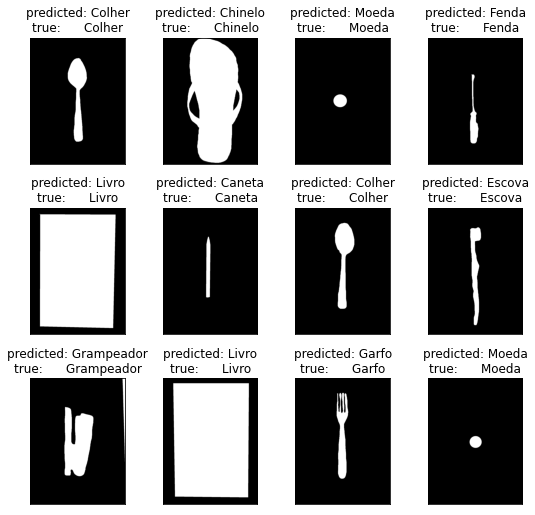

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    try:
      for i in range(n_row * n_col):
          plt.subplot(n_row, n_col, i + 1)
          plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
          plt.title(titles[i], size=12)
          plt.xticks(())
          plt.yticks(())
    except: pass

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

Vamos desenhar também os resultados gerados pelos autovetores utilizados para a classificação (os *eigenfaces* no caso de classificação de faces)

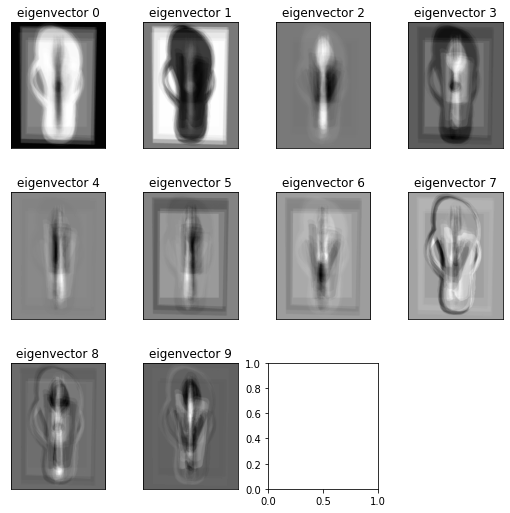

In [ ]:
eigenvector_titles = ["eigenvector %d" % i for i in range(eigenvectors.shape[0])]
plot_gallery(eigenvectors, eigenvector_titles, h, w)

plt.show()

## Conclusão

Para as imagens nos formatos trabalhados neste EP, a classificação usando PCA foi muito satisfatória, atingindo precisão alta para todas as classes. Seria interessante haver mais imagens com segmentação feita manualmente, para poder realizar mais testes ainda.

### Carregando os dados e conjuntos de treinamento e testes para segmentação automática


Vamos carregar as imagens das máscaras produzidas automaticamente:

In [ ]:
img_masks_auto = [io.imread(img_g)for img_g in imgs_g]

In [ ]:
# Quantidade de imagens para o treinamento
n_samples_auto = len(img_masks_auto)
# Dimensões das máscaras
H, W = img_masks_auto[0].shape

# Classes
target_names = np.array(['Caneta','Chinelo','Colher','Escova','Fenda','Garfo','Grampeador','Livro','Moeda','Rolha'])
n_classes = target_names.shape[0]

print(f'n_samples: {n_samples_auto}')
print(f'dimensões das imagens: {W}x{H}')
print(f'n_classes: {n_classes}')
print(f'classes: {target_names}')

n_samples: 180
dimensões das imagens: 960x1280
n_classes: 10
classes: ['Caneta' 'Chinelo' 'Colher' 'Escova' 'Fenda' 'Garfo' 'Grampeador' 'Livro'
 'Moeda' 'Rolha']


Vamos dividir os dados de máscaras (imagens binárias) que temos nos conjuntos de treinamento e de testes.

In [ ]:
# == imagens ==
# queremos as imagens como vetores unidimensionais
X_auto = np.array([arr.ravel() for arr in np.array(img_masks_auto)])
n_features_auto = X_auto.shape[1]

# == classes das imagens ==
y_auto = []

for img_g in imgs_g:
  for i_classe, classe in enumerate(target_names):
    if classe in img_g:
      y_auto.append(i_classe)

X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(
  X_auto,
  y_auto,
  test_size=0.25,
  random_state=42
)

print(f"n_features: {n_features_auto}")
print("n_samples: %d" % n_samples_auto)
print(f"tamanho do conjunto de treinamento: {len(X_train_auto)}")
print(f"tamanho do conjunto de testes: {len(X_test_auto)}")

n_features: 1228800
n_samples: 180
tamanho do conjunto de treinamento: 135
tamanho do conjunto de testes: 45


### Features e PCA para segmentação automática

A partir de agora, vamos computar a PCA e extrair as features do dataset.

In [ ]:
# A quantidade de componentes foi decidida experimentalmente
# Testamos este valor e obtivemos resultados satisfatórios
n_components = 10

print(f"Extraindo os top {n_components} PCAs de {X_train_auto.shape[0]} imagens")
t0 = time()
pca_auto = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train_auto)

print("feito em %0.3fs" % (time() - t0))

eigenvectors_auto = pca_auto.components_.reshape((n_components, H, W))

print("Projetando os dados de entrada nas bases ortonormais dos eigenvectors")
t0 = time()
X_train_pca_auto = pca_auto.transform(X_train_auto)
X_test_pca_auto = pca_auto.transform(X_test_auto)

print("feito em %0.3fs" % (time() - t0))

Extraindo os top 10 PCAs de 135 imagens
feito em 19.753s
Projetando os dados de entrada nas bases ortonormais dos eigenvectors
feito em 1.007s


### Treinamento do modelo para segmentação automática


Tendo feito a etapa anterior, podemos começar a fazer o treinamento do modelo de classificação.

In [ ]:
print("Configurando o classificador ao conjunto de treinamento")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf_auto = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf_auto = clf_auto.fit(X_train_pca_auto, y_train_auto)

print("feito em %0.3fs" % (time() - t0))

print("Melhor estimador encontrado:")
print(clf_auto.best_estimator_)

Configurando o classificador ao conjunto de treinamento
feito em 0.708s
Melhor estimador encontrado:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Avaliação do modelo para segmentação automática

---



In [ ]:
print("Predizendo as classes dos objetos nas imagens:")
t0 = time()
y_pred_auto = clf_auto.predict(X_test_pca_auto)
print("feito em %0.3fs" % (time() - t0))

print(classification_report(y_test_auto, y_pred_auto, target_names=target_names))
print(confusion_matrix(y_test_auto, y_pred_auto, labels=range(n_classes)))

Predizendo as classes dos objetos nas imagens:
feito em 0.002s
              precision    recall  f1-score   support

      Caneta       0.50      0.75      0.60         4
     Chinelo       0.67      0.80      0.73         5
      Colher       0.80      0.67      0.73         6
      Escova       0.57      0.57      0.57         7
       Fenda       0.33      0.50      0.40         2
       Garfo       1.00      0.67      0.80         3
  Grampeador       0.67      0.40      0.50         5
       Livro       1.00      0.67      0.80         6
       Moeda       0.60      0.75      0.67         4
       Rolha       0.50      0.67      0.57         3

    accuracy                           0.64        45
   macro avg       0.66      0.64      0.64        45
weighted avg       0.69      0.64      0.65        45

[[3 0 0 1 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 1]
 [2 0 4 0 0 0 0 0 0 0]
 [0 0 1 4 1 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 1 0]
 [0 0 0 1 0 2 0 0 0 0]
 [0 1 0 1 1 0 2 0 0 0]
 [1 1 0 0 0 0 0 4

Usando apenas as imagens feitas com segmentação automática nos conjuntos de treinamento e de testes, obtivemos .

Vamos desenhar os resultados:

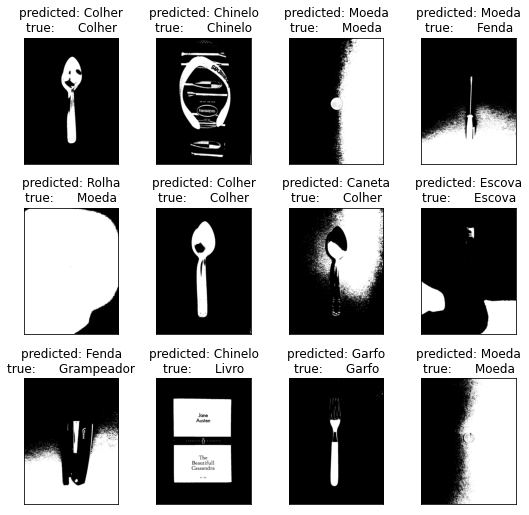

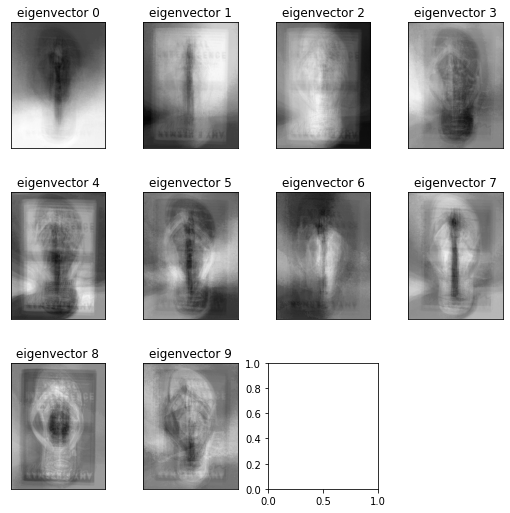

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    try:
      for i in range(n_row * n_col):
          plt.subplot(n_row, n_col, i + 1)
          plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
          plt.title(titles[i], size=12)
          plt.xticks(())
          plt.yticks(())
    except: pass

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred_auto, y_test_auto, target_names, i)
                     for i in range(y_pred_auto.shape[0])]
plot_gallery(X_test_auto, prediction_titles, H, W)

eigenvector_titles_auto = ["eigenvector %d" % i for i in range(eigenvectors_auto.shape[0])]
plot_gallery(eigenvectors_auto, eigenvector_titles_auto, H, W)

plt.show()

## Conclusão

Como esperado para as imagens segmentadas automaticamente, a precisão da classificação usando PCA teve uma precisão mais baixa do que para as imagens segmentadas manualmente devido a falta de clareza de algumas segmentações proveniente da grande variação de tonalidade entre as imagens. Entretanto, mesmo assim a classificação apresentou resultados razoáveis em algumas classes, com precisão de mais de 60%. Seria interessante explorar diferentes técnicas de segmentação automática para poder realizar mais testes ainda.